# MMM Example Notebook - Time Varying Coefficients


**Author:** [Juan Orduz](https://juanitorduz.github.io/)
**Main Reference:** [Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/)

---
# Part I: Data Generation Process

For this example we use simulated data.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

from pymmmc.transformers import geometric_adstock_vectorized, logistic_saturation
from pymmmc.utils import generate_fourier_modes

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

/Users/juanitorduz/opt/anaconda3/envs/pymmmc_env/lib/python3.8/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/juanitorduz/opt/anaconda3/envs/pymmmc_env/lib/python3.8/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Generate Data

See [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/).

### 1. Date Range

In [2]:
SEED = 42
np.random.seed(SEED)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

data_df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = data_df.shape[0]

### 2. Media Costs Data

- Raw Signal

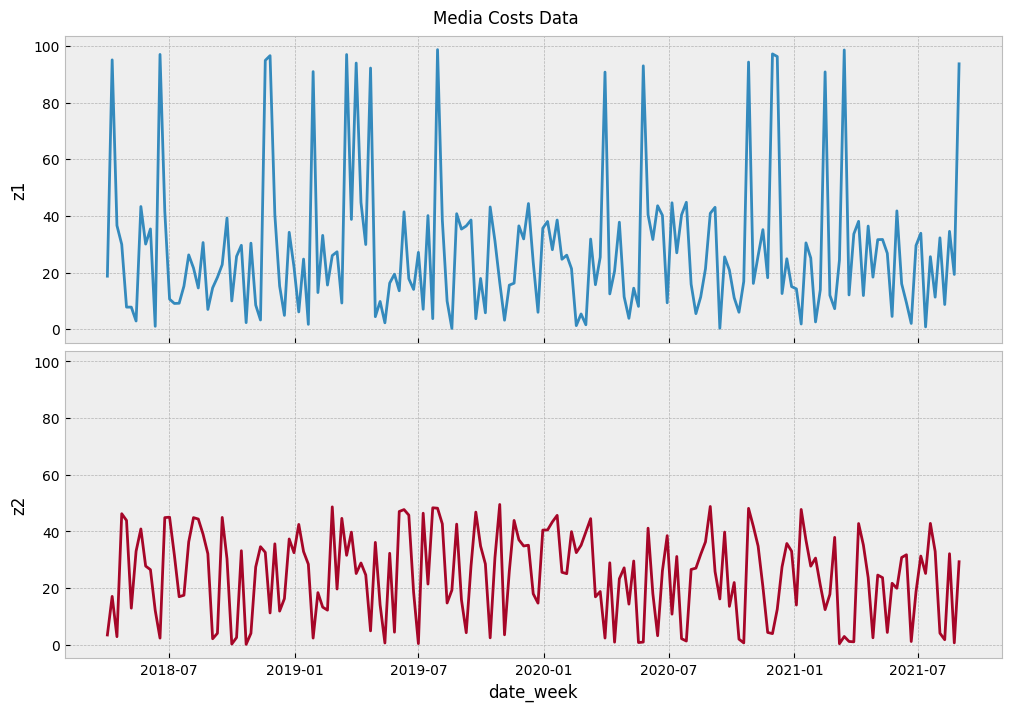

In [3]:
# media data
z1 = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z1"] = 100 * np.where(z1 > 0.9, z1, z1 / 2)

z2 = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z2"] = 50 * np.where(z2 > 0.2, z2, z2 / 2)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="z1", data=data_df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="z2", data=data_df, color="C1", ax=ax[1])
fig.suptitle("Media Costs Data");

- Effect Signal

In [4]:
# scale features
data_df["z1_scaled"] = MinMaxScaler().fit_transform(X=data_df[["z1"]])

data_df["z2_scaled"] = MinMaxScaler().fit_transform(X=data_df[["z2"]])

# apply saturation transformation
lam1 = 5
lam2 = 3

data_df["z1_saturated"] = logistic_saturation(
    x=data_df["z1_scaled"].to_numpy(), lam=lam1
).eval()

data_df["z2_saturated"] = logistic_saturation(
    x=data_df["z2_scaled"].to_numpy(), lam=lam2
).eval()

# apply geometric adstock transformation
alpha1 = 0.7
alpha2 = 0.3

data_df["z1_saturated_adstock"] = (
    geometric_adstock_vectorized(
        x=data_df[["z1_saturated"]].to_numpy(), alpha=alpha1, l_max=12, normalize=False
    )
    .eval()
    .flatten()
)

data_df["z2_saturated_adstock"] = (
    geometric_adstock_vectorized(
        x=data_df[["z2_saturated"]].to_numpy(), alpha=alpha2, l_max=12, normalize=False
    )
    .eval()
    .flatten()
)

# time-varying factors
data_df["g1"] = 1.0
data_df["g2"] = 0.5 * (np.sin(2 * np.pi * 0.6 * data_df["date_week"].dt.dayofyear / 365.25) + 1.25)

# channel effects
data_df["z1_effect"] = data_df["g1"] * data_df["z1_saturated_adstock"]
data_df["z2_effect"] = data_df["g2"] * data_df["z2_saturated_adstock"]

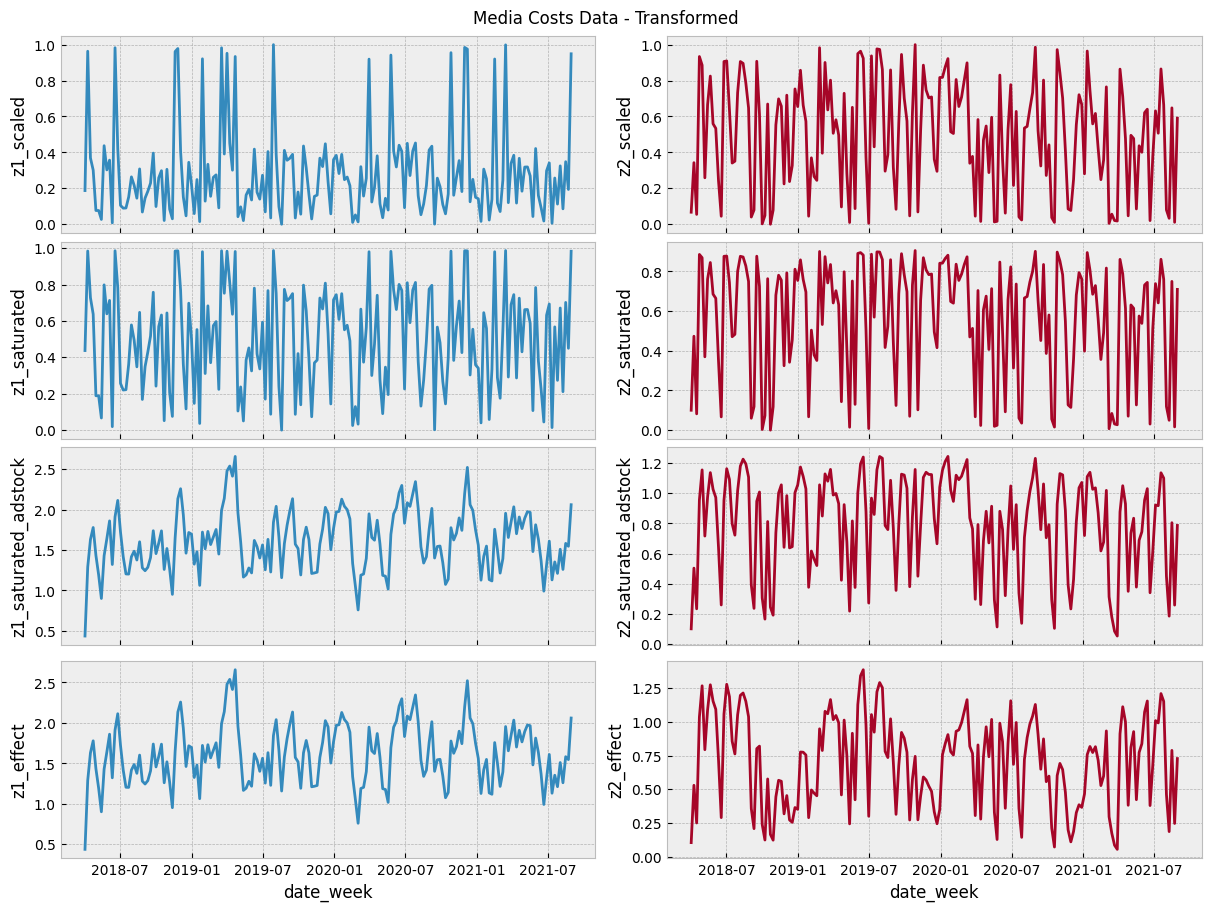

In [5]:
fig, ax = plt.subplots(
    nrows=4, ncols=2, figsize=(12, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="z1_scaled", data=data_df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="z2_scaled", data=data_df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="z1_saturated", data=data_df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="z2_saturated", data=data_df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="z1_saturated_adstock", data=data_df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="z2_saturated_adstock", data=data_df, color="C1", ax=ax[2, 1])
sns.lineplot(x="date_week", y="z1_effect", data=data_df, color="C0", ax=ax[3, 0])
sns.lineplot(x="date_week", y="z2_effect", data=data_df, color="C1", ax=ax[3, 1])
fig.suptitle("Media Costs Data - Transformed");

### Trend \& Seasonal Components

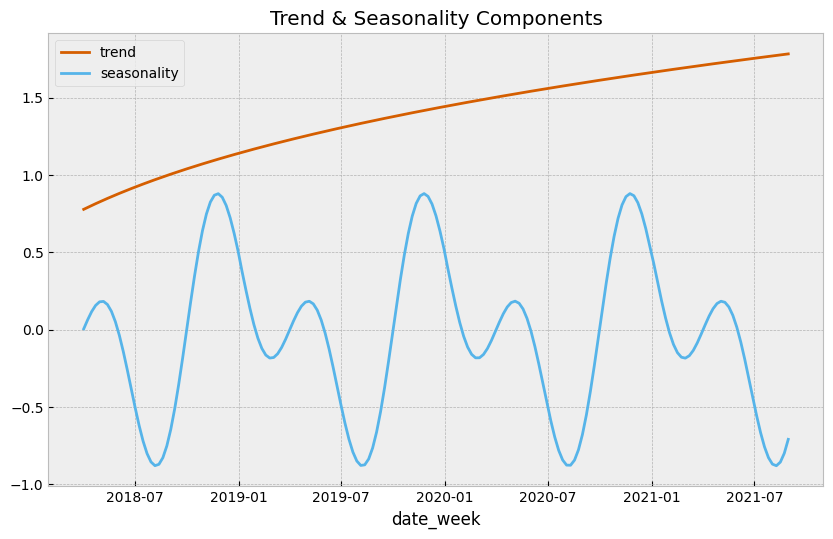

In [6]:
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

data_df["cs"] = - np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.5) 
data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.5)
data_df["seasonality"] = 0.5 * (data_df["cs"] + data_df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C4", label="trend", data=data_df, ax=ax)
sns.lineplot(x="date_week", y="seasonality", color="C6", label="seasonality", data=data_df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", ylabel=None);

### Target Variable

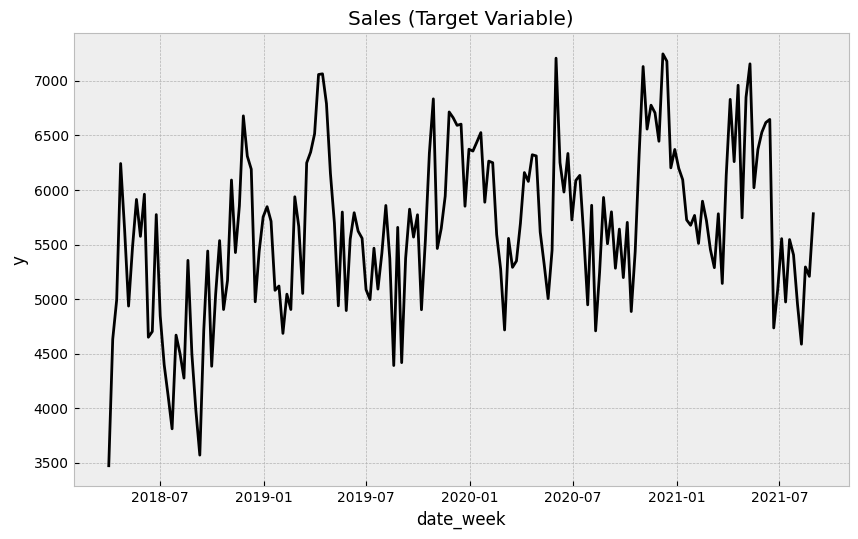

In [7]:
np.random.seed(SEED)

data_df["intercept"] = 2.0
data_df["epsilon"] = np.random.normal(loc=0.0, scale=0.3, size=n)

data_df["y"] = 1_000 * (
    data_df["intercept"]
    + data_df["trend"]
    + data_df["seasonality"]
    + data_df["z1_effect"]
    + data_df["z2_effect"]
    + data_df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=data_df, ax=ax)
ax.set(title="Sales (Target Variable)");

---

# Part II: Modeling

## 1. Define Model Input

In [8]:
# get features available for modeling
df = data_df[["date_week", "y", "z1", "z2", "dayofyear"]].copy()

# date
date_week = df["date_week"].dt.date.to_numpy()

# target
target = "y"
y = df[target].to_numpy()
n_obs = y.shape[0]

# channels
channels =["z1", "z2"]
channels_df = df[channels].copy()
n_channels = len(channels)

# control variables
df["linear_trend"] = np.linspace(start=0, stop=n, num=n)
control = ["linear_trend"]
control_df = df[control].copy()
n_control = len(control)

features = channels + control

exog_df = df[features]

# Fourier modes
n_order = 3
fourier_features = generate_fourier_modes(
    periods=df["dayofyear"] / 365.25,
    n_order=n_order,
)

## 2. Scale Features

In [9]:
endog_scaler = StandardScaler()
scaled_y = endog_scaler.fit_transform(y.reshape(-1, 1)).ravel()

channels_scaler = MinMaxScaler()
scaled_channels_df = pd.DataFrame(
    data=channels_scaler.fit_transform(X=channels_df), columns=channels_df.columns
)

control_scaler = MinMaxScaler()
scaled_control_df = pd.DataFrame(
    data=control_scaler.fit_transform(X=control_df), columns=control_df.columns
)

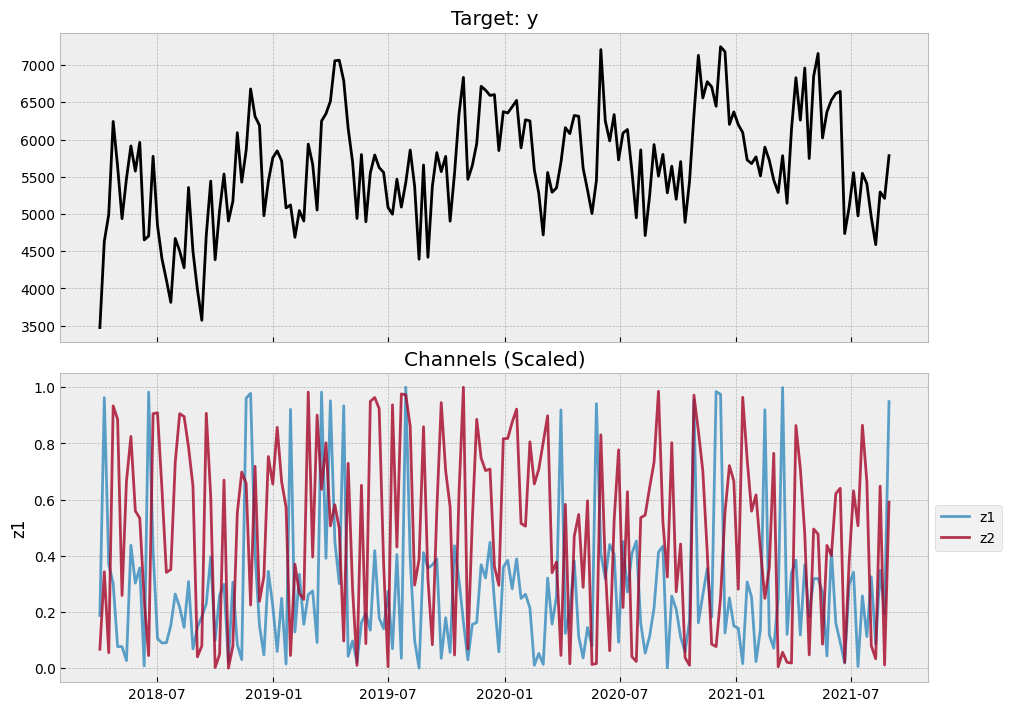

In [10]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 7),
    sharex=True,
    sharey=False,
    layout="constrained",
)

sns.lineplot(x=date_week, y=y, color="black", ax=ax[0])

for i, channel in enumerate(channels):
    sns.lineplot(
        x=date_week,
        y=scaled_channels_df[channel],
        color=f"C{i}",
        alpha=0.8,
        label=f"{channel}",
        ax=ax[1],
    )
ax[0].set(title=f"Target: {target}")
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set(title="Channels (Scaled)");

### 3. Model Specification

In [11]:
# define model coordinates
coords = {
    "date_week": date_week,
    "channel": channels,
    "control": control,
    "fourier_mode": fourier_features.columns.to_numpy(),
}

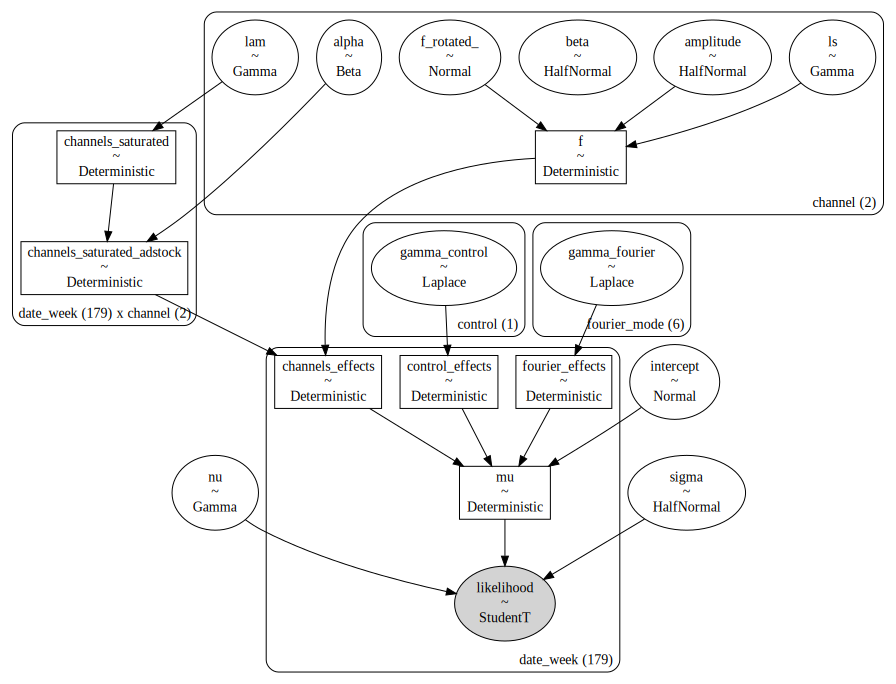

In [17]:
with pm.Model(coords=coords) as model:
    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    # coefficients marketing channels
    beta = pm.HalfNormal(name="beta", sigma=2, dims="channel")
    # adstock parameter
    alpha = pm.Beta(name="alpha", alpha=1, beta=3, dims="channel")
    # saturation parameter
    lam = pm.Gamma(name="lam", alpha=3, beta=1, dims="channel")
    # coefficients control variables
    gamma_control = pm.Laplace(name="gamma_control", mu=0, b=1, dims="control")
    # coefficients fourier modes
    gamma_fourier = pm.Laplace(name="gamma_fourier", mu=0, b=1, dims="fourier_mode")
    # likelihood standard deviation
    sigma = pm.HalfNormal(name="sigma", sigma=2)
    # degrees of freedom
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- Model Parametrization ---
    # marketing channel effects
    ## saturated-adstock
    channels_saturated = pm.Deterministic(
        name="channels_saturated",
        var=logistic_saturation(x=scaled_channels_df.to_numpy(), lam=lam),
        dims=("date_week", "channel"),
    )
    channels_saturated_adstock = pm.Deterministic(
        name="channels_saturated_adstock",
        var=geometric_adstock_vectorized(
            x=channels_saturated,
            alpha=alpha,
            l_max=12,
            normalize=True,
        ),
        dims=("date_week", "channel"),
    )

    # TODO: Make this Gaussian Process Work
    amplitude = pm.HalfNormal(name="amplitude", sigma=0.8, dims="channel")
    ls = pm.Gamma(name="ls", alpha=5, beta=2, dims="channel")
    cov = amplitude ** 2 * pm.gp.cov.Exponential(input_dim=2, ls=ls)
    gp = pm.gp.Latent(cov_func=cov)
    x = np.hstack(
        [np.linspace(start=1, stop=n, num=n)[..., None] for _ in range(n_channels)]
    ) # ? Include as coordinate?
    f = gp.prior("f", X=x, dims="channel")

    channels_effects = pm.Deterministic(
        name="channels_effects",
        var=pm.math.dot(channels_saturated_adstock, f),
        dims=("date_week"),
    )
    # control variables effect
    control_effects = pm.Deterministic(
        name="control_effects",
        var=pm.math.dot(scaled_control_df.to_numpy(), gamma_control),
        dims="date_week",
    )
    # fourier modes effect
    fourier_effects = pm.Deterministic(
        name="fourier_effects",
        var=pm.math.dot(fourier_features.to_numpy(), gamma_fourier),
        dims="date_week",
    )

    mu = pm.Deterministic(
        name="mu",
        var=intercept + channels_effects + control_effects + fourier_effects,
        dims="date_week",
    )

    # --- Likelihood ---
    likelihood = pm.StudentT(
        "likelihood", mu=mu, nu=nu, sigma=sigma, dims="date_week", observed=scaled_y
    )

pm.model_to_graphviz(model)

### 4. Prior Predictive Checks

In [15]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1000)

ERROR (aesara.graph.opt): Optimization failure due to: constant_folding
ERROR (aesara.graph.opt): node: Assert{msg=Could not broadcast dimensions}(ScalarConstant{179}, TensorConstant{False})
ERROR (aesara.graph.opt): TRACEBACK:
ERROR (aesara.graph.opt): Traceback (most recent call last):
  File "/Users/juanitorduz/opt/anaconda3/envs/pymmmc_env/lib/python3.8/site-packages/aesara/graph/opt.py", line 1861, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/Users/juanitorduz/opt/anaconda3/envs/pymmmc_env/lib/python3.8/site-packages/aesara/graph/opt.py", line 1066, in transform
    return self.fn(fgraph, node)
  File "/Users/juanitorduz/opt/anaconda3/envs/pymmmc_env/lib/python3.8/site-packages/aesara/tensor/basic_opt.py", line 2868, in constant_folding
    required = thunk()
  File "/Users/juanitorduz/opt/anaconda3/envs/pymmmc_env/lib/python3.8/site-packages/aesara/graph/op.py", line 540, in rval
    r = p(n, [x[0] for x in i], o, params)
  File "/Users/juanitorduz/opt

AssertionError: Could not broadcast dimensions

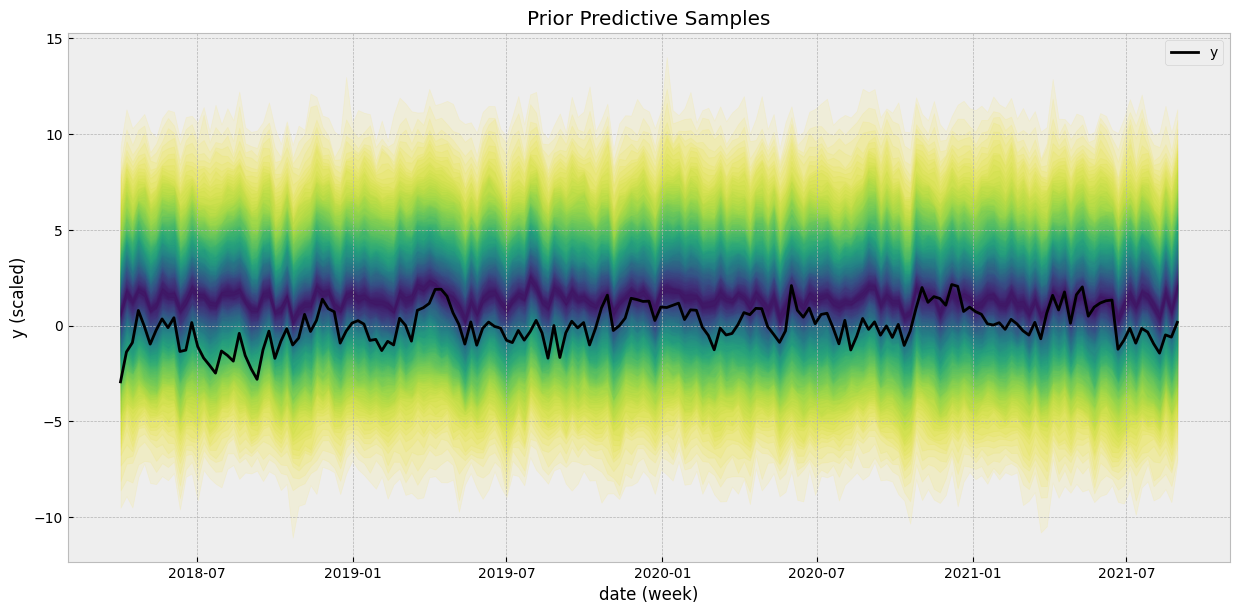

In [14]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date_week,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=date_week, y=scaled_y, label=target, color="black", ax=ax)
ax.set(
    title="Prior Predictive Samples",
    xlabel="date (week)",
    ylabel=f"{target} (scaled)",
);

### 5. Fit Model

In [15]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.95, draws=6000, chains=4
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)


Compiling...
Compilation time =  0:00:09.642218
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time =  0:00:24.980372
Transforming variables...
Transformation time =  0:00:09.636412
Computing Log Likelihood...
Log Likelihood time =  0:00:07.115445


### 6. Model Diagnostics

In [16]:
model_var_names = [
    "intercept",
    "beta",
    "alpha",
    "lam",
    "gamma_control",
    "gamma_fourier",
    "sigma",
    "nu",
]

In [17]:
az.summary(data=idata, var_names=model_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-3.848,0.212,-4.246,-3.450,0.002,0.001,17209.0,15596.0,1.0
beta[z1],4.541,0.353,3.899,5.222,0.003,0.002,16293.0,15076.0,1.0
beta[z2],1.622,0.352,1.088,2.250,0.004,0.003,11869.0,9420.0,1.0
alpha[z1],0.696,0.026,0.647,0.742,0.000,0.000,17614.0,17277.0,1.0
alpha[z2],0.218,0.083,0.062,0.372,0.001,0.000,17680.0,10810.0,1.0
lam[z1],5.636,0.651,4.425,6.854,0.004,0.003,21952.0,16748.0,1.0
lam[z2],2.842,0.816,1.320,4.370,0.007,0.005,13768.0,9256.0,1.0
gamma_control[linear_trend],1.317,0.110,1.104,1.519,0.001,0.001,23240.0,18214.0,1.0
gamma_fourier[sin_order_1],0.176,0.043,0.095,0.256,0.000,0.000,27578.0,18014.0,1.0
gamma_fourier[cos_order_1],0.344,0.043,0.266,0.427,0.000,0.000,28857.0,16549.0,1.0


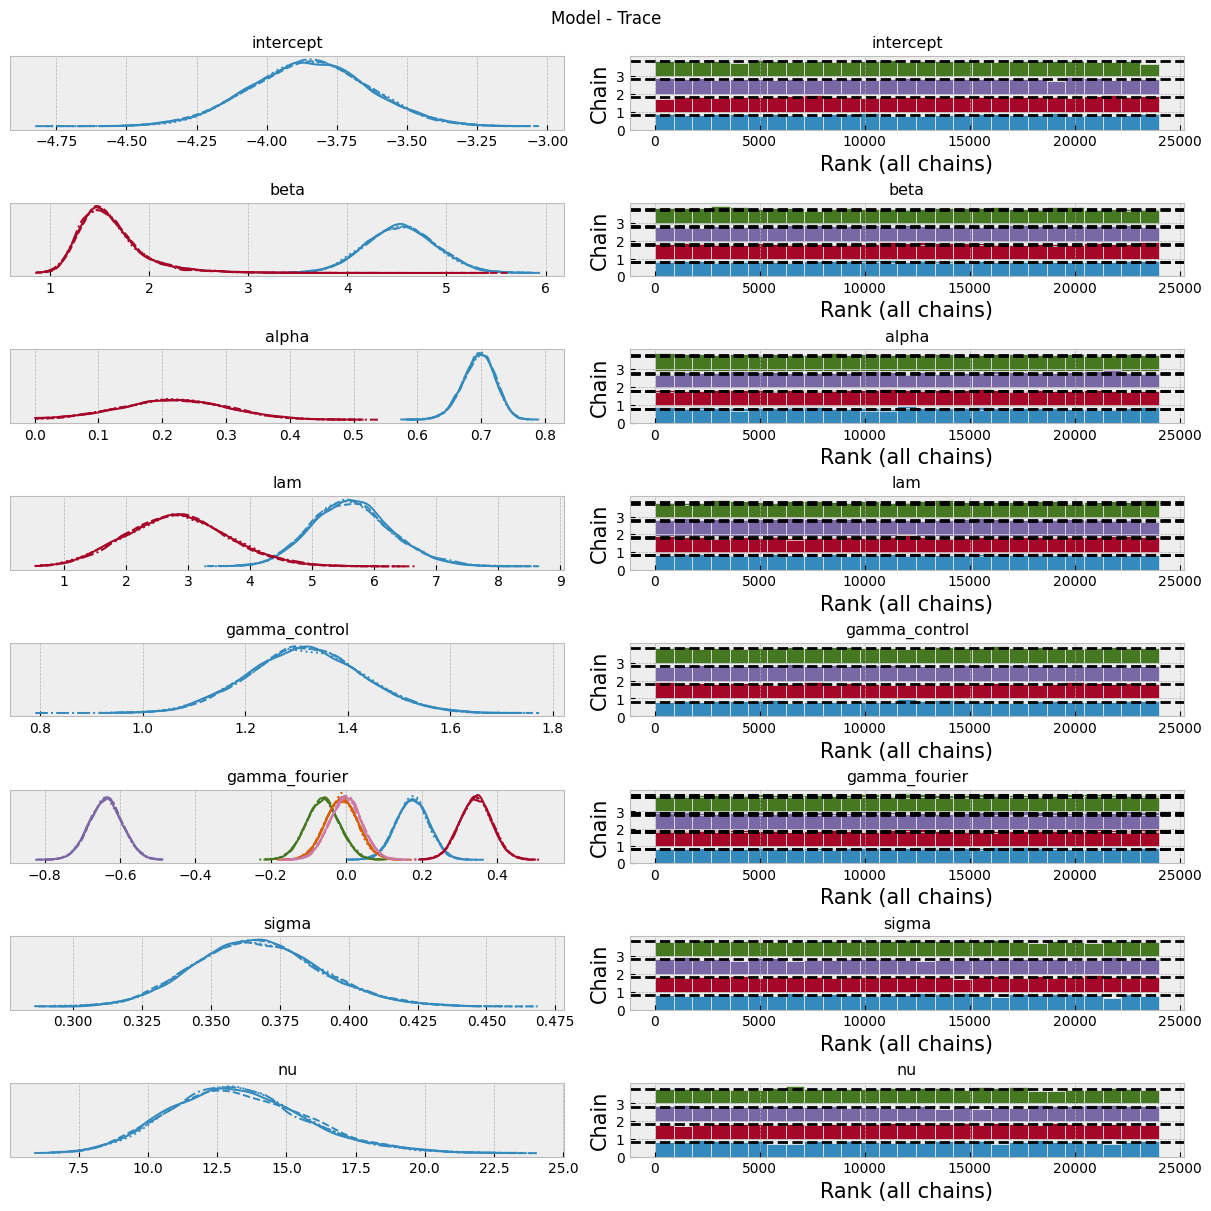

In [18]:
axes = az.plot_trace(
    data=idata,
    var_names=model_var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Model - Trace");

Text(0.5, 1.05, 'Model - Posterior Distributions - Channels')

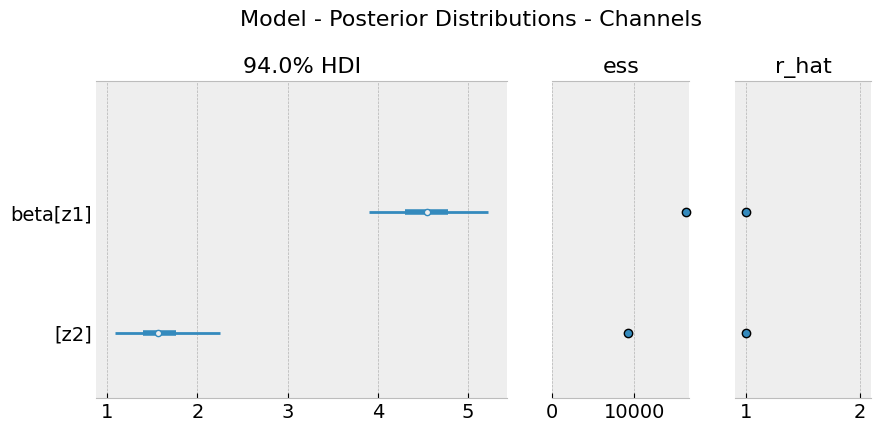

In [19]:
ax = az.plot_forest(
    data=idata,
    var_names=["beta"],
    combined=True,
    r_hat=True,
    ess=True,
)
plt.gcf().suptitle(
    "Model - Posterior Distributions - Channels", fontsize=16, y=1.05
)